<a href="https://colab.research.google.com/github/cisirtraining/summerschool/blob/master/Day1_Introduction_to_DL_framework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Salt segmentation using Keras**

This is to segment salt deposits beneath the Earth's surface. Data is from TGS Salt Identification Challenge (https://www.kaggle.com/c/tgs-salt-identification-challenge/data). The architecture used in this work is called U-net, which is common for segmentation problems, please check here (https://arxiv.org/pdf/1505.04597.pdf) for the original paper on U-net.

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm 
from skimage.io import imshow 
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import cv2

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D 
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img 

# Working directory
root = '/content/drive/My Drive/data/data_seismic/'

**Functions**

In [34]:
def get_data(path, im_height, im_width, im_chan):
    '''load the images and resize each image to (im_height,im_width, im_chan)'''
    ids = next(os.walk(path + '/images/'))[2]
    X = np.zeros((len(ids), im_height, im_width, im_chan), dtype=np.float32)
    y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images...')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)): # TODO: take only 10% for testing later 
        img = img_to_array(load_img(path + '/images/' + id_))
        img = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
        mask = img_to_array(load_img(path + '/masks/' + id_))
        mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
        X[n] = img/ 255
        y[n] = mask/255
    print('Done!')
    return X,y

# Build U-Net model
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    '''Function to add 2 convolutional layers with the parameters passed to it'''
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

def unet(input_img, n_filters=16, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1) 
    
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


**Training**

In [35]:
# # Save "X_train, X_valid, y_train, y_valid" as npz data format (One time)

# X, y = get_data(root, 128, 128,1)
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

# with open(root+'X_train.npy', 'wb') as f:
#     np.save(f, X_train)

# with open(root+'X_valid.npy', 'wb') as f:
#     np.save(f, X_valid)

# with open(root+'y_train.npy', 'wb') as f:
#     np.save(f, y_train)

# with open(root+'y_valid.npy', 'wb') as f:
#     np.save(f, y_valid)

In [36]:
with open(root+'X_train.npy', 'rb') as f:
    X_train = np.load(f)

with open(root+'X_valid.npy', 'rb') as f:
    X_valid = np.load(f)

with open(root+'y_train.npy', 'rb') as f:
    y_train = np.load(f)

with open(root+'y_valid.npy', 'rb') as f:
    y_valid = np.load(f)

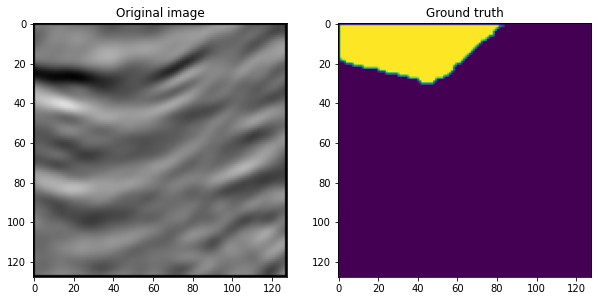

In [49]:
# show some random data
rnd_int = np.random.randint(X_train.shape[0], size=1)[0]
fig = plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(X_train[rnd_int].squeeze(), cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.subplot(122)
plt.imshow(y_train[rnd_int].squeeze())
plt.title('Ground truth')
plt.show()

In [38]:
input_img = Input((128, 128, 1), name='img')
model = unet(input_img)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 128, 16) 0           batch_normalization_18[0][0]     
_______________________________________________________________________________________

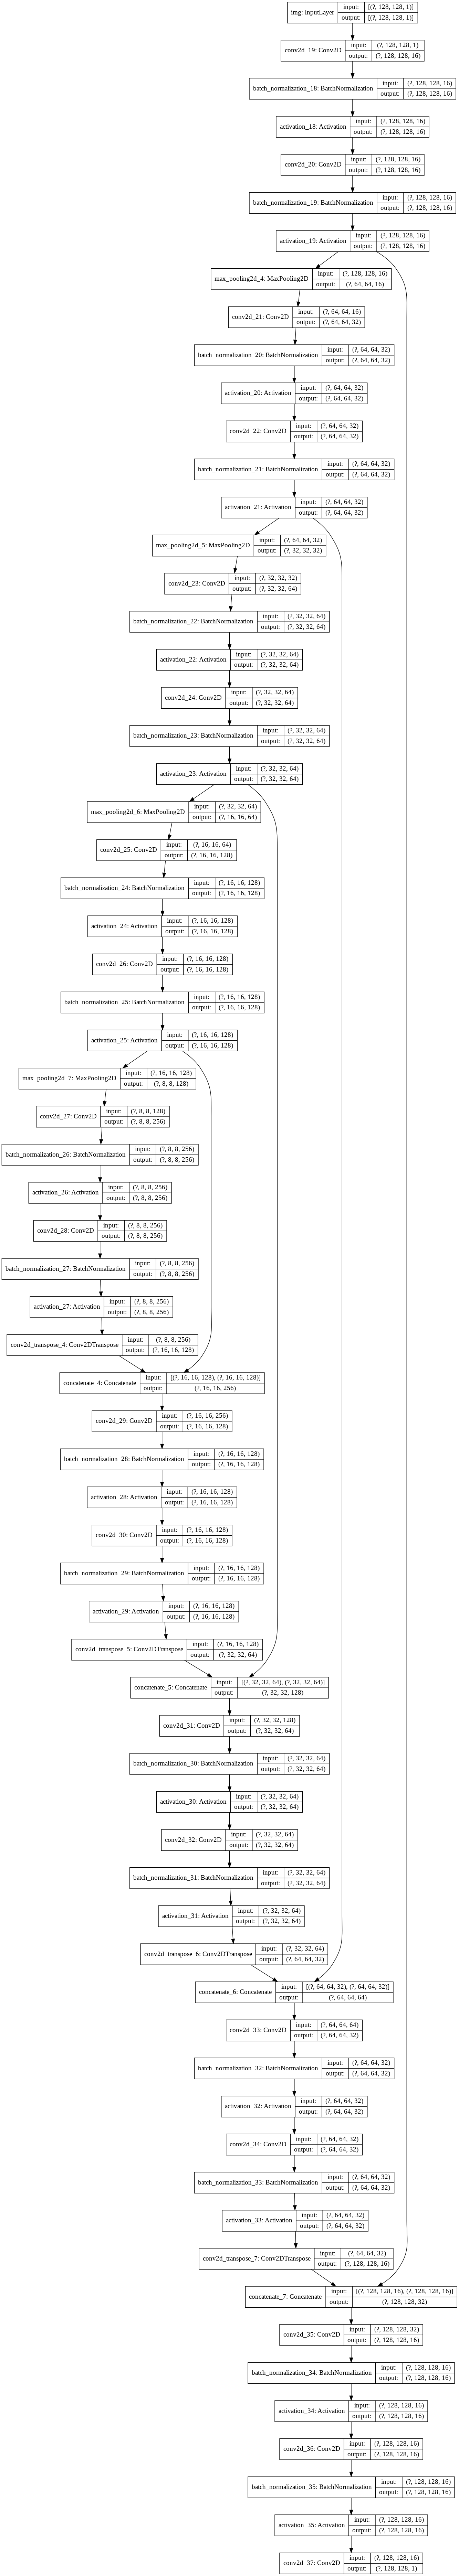

In [39]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='myUNet_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
import time
start = time.time()
callbacks = [
EarlyStopping(patience=10, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1),
ModelCheckpoint(root+'model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=4, epochs=30, callbacks=callbacks,validation_data=(X_valid, y_valid))
end = time.time()
print('execution time:',end-start)

Epoch 1/30
849/850 [============================>.] - ETA: 0s - loss: 0.5059 - accuracy: 0.6145
Epoch 00001: val_loss improved from inf to 0.36896, saving model to /content/drive/My Drive/data/data_seismic/model1.h5
850/850 [==============================] - 13s 16ms/step - loss: 0.5058 - accuracy: 0.6147 - val_loss: 0.3690 - val_accuracy: 0.7098
Epoch 2/30
849/850 [============================>.] - ETA: 0s - loss: 0.3867 - accuracy: 0.6895
Epoch 00002: val_loss improved from 0.36896 to 0.32051, saving model to /content/drive/My Drive/data/data_seismic/model1.h5
850/850 [==============================] - 14s 16ms/step - loss: 0.3866 - accuracy: 0.6895 - val_loss: 0.3205 - val_accuracy: 0.7251
Epoch 3/30
848/850 [============================>.] - ETA: 0s - loss: 0.3469 - accuracy: 0.7048
Epoch 00003: val_loss did not improve from 0.32051
850/850 [==============================] - 13s 15ms/step - loss: 0.3473 - accuracy: 0.7046 - val_loss: 0.3501 - val_accuracy: 0.6904
Epoch 4/30
849/850

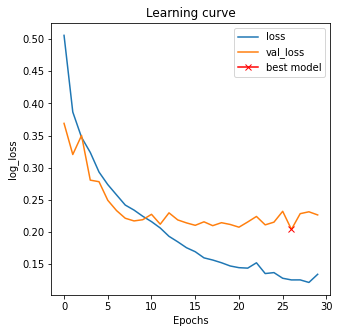

In [41]:
plt.figure(figsize=(5, 5))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Check the predictions**

In [42]:
#import the best model and evaluate its performance on validation data
model.load_weights(root+'model1.h5')
model.evaluate(X_valid, y_valid, verbose=1)

19/19 [==============================] - 1s 28ms/step - loss: 0.2040 - accuracy: 0.7401


[0.20402173697948456, 0.7401488423347473]

In [43]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

19/19 [==============================] - 0s 24ms/step


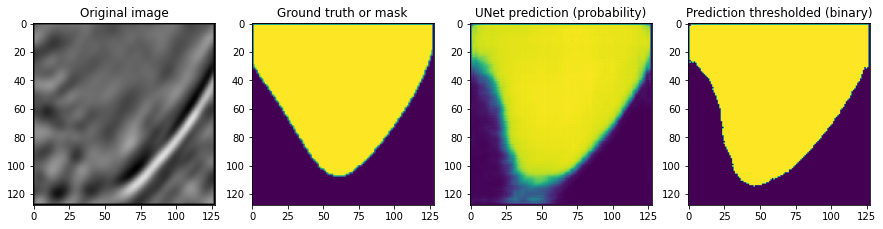

In [48]:
rnd_int = np.random.randint(X_train.shape[0], size=1)[0]
fig = plt.figure(figsize = (15,15))
plt.subplot(141)
plt.imshow(cv2.cvtColor(X_train[rnd_int].squeeze(), cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.subplot(142)
plt.imshow(y_train[rnd_int].squeeze())
plt.title('Ground truth or mask')
plt.subplot(143)
plt.imshow(preds_train[rnd_int].squeeze())
plt.title('UNet prediction (probability)')
plt.subplot(144)
plt.imshow(preds_train_t[rnd_int].squeeze())
plt.title('Prediction thresholded (binary)')
plt.show()

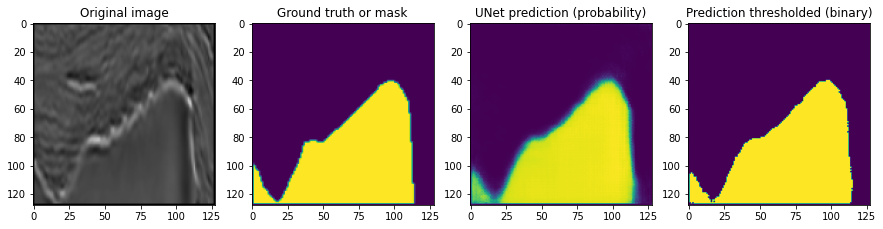

In [51]:
rnd_int = np.random.randint(X_valid.shape[0], size=1)[0]
fig = plt.figure(figsize = (15,15))
plt.subplot(141)
plt.imshow(cv2.cvtColor(X_valid[rnd_int].squeeze(), cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.subplot(142)
plt.imshow(y_valid[rnd_int].squeeze())
plt.title('Ground truth or mask')
plt.subplot(143)
plt.imshow(preds_val[rnd_int].squeeze())
plt.title('UNet prediction (probability)')
plt.subplot(144)
plt.imshow(preds_val_t[rnd_int].squeeze())
plt.title('Prediction thresholded (binary)')
plt.show()